# Práctica 3. Resolución numérica de PVIs

> Alumno: Miguel Ángel Fernández Gutiérrez ([mianfg@correo.ugr.es](mailto:mianfg@correo.ugr.es))
>
> 3º Doble Grado en Ingeniería Informática y Matemáticas, 2019/2020

###### Importar módulos de Python necesarios

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from time import perf_counter as now

Son especialmente interesantes las implementaciones de:

* Una función `comparar_metodos`, que toma como entrada los nombres de los módulos de diversos métodos y como salida da las aproximaciones de cada uno, así como los tiempos de ejecución, para varios valores de $N$ en función de un cierto $i$ y un cierto paso (en [ejercicio 1](#Solución-al-ejercicio-1)).
* El módulo `rk` (en [ejercicio 6](#Solución-al-ejercicio-6)):
  * Una clase `Butcher`, que implementa de forma genérica un arreglo de Butcher.
  * El método `integrate`, que realiza cualquier RK explícito a partir de un arreglo de Butcher de tipo `Butcher`.

## Métodos de Euler

### Ejercicio 1

Repita las aproximaciones anteriores con diferentes valores de $N$ (y por tanto de $h$) y compruebe el efecto en cuanto a mayor o menor precisión, estabilidad y coste computacional.

#### Solución al ejercicio 1

Primero crearemos un módulo para cada uno de los métodos programados hasta ahora:

* Método de Euler explícito: `eulerexplicito`
* Método de Euler implícito: `eulerimplicito`
* Método de Euler implícito aproximado: `eulerimplicitoaprox`

In [2]:
%%file   eulerexplicito.py
## módulo eulerexplicito
''' método de Euler para resolver el PVI
    X,Y     = integrate(F,x0,y0,xfinal,N).
    {y}'    = {F(x,{y})}, donde
    {y}     = {y[0],y[1],...y[N-1]}.
    x0,y0   = condiciones iniciales 
    xfinal  = valor final de la variable x
    h       = incremento de x usado para la integración
    F       = función suplida por el usuario que devuelve 
            el array F(x,y) = {y'[0],y'[1],...,y'[N-1]}.
'''
import numpy as np
def integrate(F,x0,y0,xfinal,N):    
    X = np.linspace(x0,xfinal,N+1)
    Y = [y0]; h = (xfinal-x0)/N
    for n in range(N):
        Y.append(Y[n] + h*F(X[n],Y[n]))
    return np.array(X),np.array(Y)

Overwriting eulerexplicito.py


In [3]:
%%file eulerimplicito.py
## módulo eulerimplicito
''' método de Euler implicito para resolver el PVI
    X,Y     = integrate(F,x0,y0,xfinal,N).
    {y}'    = {F(x,{y})}, donde
    {y}     = {y[0],y[1],...y[N-1]}.
    x0,y0   = condiciones iniciales 
    xfinal  = valor final de la variable x
    h       = incremento de x usado para la integración
    F       = función suplida por el usuario que devuelve 
            el array F(x,y) = {y'[0],y'[1],...,y'[N-1]}.
'''
import numpy as np
import sympy as sp
def integrate(F,x0,y0,xfinal,N):    
    X = np.linspace(x0,xfinal,N+1)
    Y = [y0]; h = (xfinal-x0)/N
    y1 = sp.Symbol('y1') # usaremos esta variable como incógnita
    for n in range(N):   # de la ecuación a resolver en cada iteración
        Y.append(sp.solve(Y[n]+h*F(X[n+1],y1)-y1,y1)[0])
    return np.array(X),np.array(Y)

Overwriting eulerimplicito.py


In [4]:
%%file eulerimplicitoaprox.py
## módulo eulerimplicitoaprox
''' método de Euler implicito aprox para resolver el PVI
    X,Y     = integrate(F,x0,y0,xfinal,N).
    {y}'    = {F(x,{y})}, donde
    {y}     = {y[0],y[1],...y[N-1]}.
    x0,y0   = condiciones iniciales 
    xfinal  = valor final de la variable x
    h       = incremento de x usado para la integración
    F       = función suplida por el usuario que devuelve 
            el array F(x,y) = {y'[0],y'[1],...,y'[N-1]}.
'''
import numpy as np
import sympy as sp

def integrate(F,x0,y0,xfinal,N):    
    X = np.linspace(x0,xfinal,N+1)
    Y = [y0]; h = (xfinal-x0)/N
    
    for n in range(N):   
        y1 = Y[n] + h*F(X[n],Y[n])    #  valor inicial para una
        Y.append(Y[n]+h*F(X[n+1],y1)) #  iteración de punto fijo
    return np.array(X),np.array(Y)

Overwriting eulerimplicitoaprox.py


Partimos del PVI que aparece al principio de la práctica:$$x'=f(t,x)=t,\;x(0)=1,\;t\in[0,1]$$

In [5]:
t, y0, z = sp.symbols('t, y_0,  z')
def f(t,z):
    return z

a = 0; b = 1;   # extremos inferior y superior del intervalo 
ya = 1          # condición inicial del PVI

Ejecutaremos cada uno de los métodos para diferentes valores de $N$, por ejemplo, con $N=5+5i,i=0,1,...,5$. Insertaremos las aproximaciones en un vector `y`, en el que `y[i][metodo]` corresponderá a las aproximaciones con $N=5+5i$ para el método `metodo`; y los tiempos de ejecución en un vector `tiempos`, en el que `tiempos[i][metodo]` corresponderá al tiempo de ejecución con $N=5+5i$ para el método `metodo`.

Definimos primero una función genérica para comparar métodos numéricos. Nótese que los argumentos `**args` serán los argumentos pasados a la función `integrate` de cada uno de los módulos concretados en `modulos`.

> **Nota importante:** la función `comparar_metodos` toma como entrada `*args`, que es una lista de los parámetros de las funciones `integrate`. Para que no arroje una excepción, las funciones `integrate` deben tener los **mismos parámetros** y deben tener el parámetro `N` (número de iteraciones) **al final**. No tendremos problema con esto, pues todos los métodos de un paso programados tienen los mismos argumentos y en el mismo orden (excepto `eulerexplrapido`).

In [6]:
def comparar_metodos(metodos, fN, iters, *args):
    x = []
    y = []
    tiempos = []
    metodos = list( dict.fromkeys(metodos) )   # que no se repitan métodos

    print("Comparando los métodos", metodos)
    print(f"Ejecutando {iters} iteraciones de valores de N...\n│ ")

    for i in range(iters):
        N = fN(i)
        print(f"{'└' if i == iters-1 else '├'}── Calculando para i={i}, N={N}")
        _y, _t = {}, {}
        for metodo in metodos:
            # de este modo llamamos a metodo.integrate
            module = __import__(metodo)
            func = getattr(module, "integrate")

            # contabilizamos el tiempo
            _t0 = now()
            _x, _y[metodo] = func(*args, N=N)
            _t1 = now()
            print(f"{' ' if i == iters-1 else '│'}   {'└' if metodo == metodos[-1] else '├'}── Finalizado método \'{metodo}\'")
            print(f"{' ' if i == iters-1 else '│'}   {' ' if metodo == metodos[-1] else '│'}   └── Tiempo de ejecución: {_t1-_t0}")

            _t[metodo] = _t1 - _t0
        x.append(_x); y.append(_y); tiempos.append(_t)
    
    print("\nMétodos ejecutados correctamente")
    return x, y, tiempos

Ejecutamos la función para comparar los métodos.

In [7]:
metodos = ["eulerexplicito", "eulerimplicito", "eulerimplicitoaprox"]
x, y, tiempos = comparar_metodos(metodos, lambda i: 5+5*i, 6, f, a, ya, b)

Comparando los métodos ['eulerexplicito', 'eulerimplicito', 'eulerimplicitoaprox']
Ejecutando 6 iteraciones de valores de N...
│ 
├── Calculando para i=0, N=5
│   ├── Finalizado método 'eulerexplicito'
│   │   └── Tiempo de ejecución: 0.00011245499626966193
│   ├── Finalizado método 'eulerimplicito'
│   │   └── Tiempo de ejecución: 0.07040485300240107
│   └── Finalizado método 'eulerimplicitoaprox'
│       └── Tiempo de ejecución: 0.00013081999350106344
├── Calculando para i=1, N=10
│   ├── Finalizado método 'eulerexplicito'
│   │   └── Tiempo de ejecución: 7.469500269507989e-05
│   ├── Finalizado método 'eulerimplicito'
│   │   └── Tiempo de ejecución: 0.15736474200093653
│   └── Finalizado método 'eulerimplicitoaprox'
│       └── Tiempo de ejecución: 0.0002733750006882474
├── Calculando para i=2, N=15
│   ├── Finalizado método 'eulerexplicito'
│   │   └── Tiempo de ejecución: 0.00011854100011987612
│   ├── Finalizado método 'eulerimplicito'
│   │   └── Tiempo de ejecución: 0.26668868

En `x`, `y`, `tiempos` tenemos toda la información necesaria para comparar estos tres métodos.

Primeramente, compararemos los tiempos de ejecución:

Text(0.5, 1.0, 'Tiempos de ejecución')

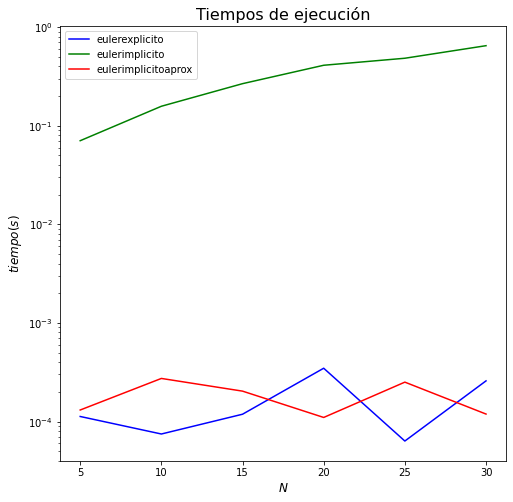

In [8]:
nv = [5+5*i for i in range(6)]
fig,ax = plt.subplots(figsize=(8,8))
colors = "bgr"
for metodo in metodos:
    ax.plot(nv,[tiempos[i][metodo] for i in range(6)],colors[metodos.index(metodo)],label=metodo)
ax.set_yscale("log")
ax.legend(loc='upper left')
ax.set_xlabel('$N$',fontsize=12)
ax.set_ylabel('$tiempo (s)$',fontsize=12)
ax.set_title('Tiempos de ejecución',fontsize=16)

Finalmente veamos cómo de buenas son las aproximaciones, tanto 

Text(0.5, 1.0, 'Aproximaciones')

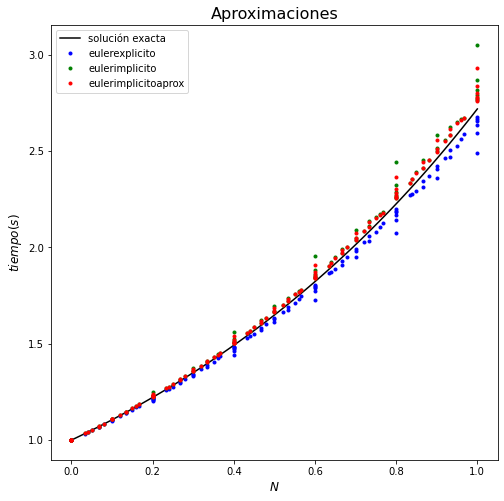

In [9]:
fig,ax = plt.subplots(figsize=(8,8))
xx = np.linspace(a,b,100)
yy = [np.exp(x) for x in xx]
colors = "bgr"
ax.plot(xx,yy,'k',label='solución exacta')
for metodo in metodos:
    ax.plot(x[0],y[0][metodo],colors[metodos.index(metodo)]+'.',label=metodo)
    for i in range(1,6):
        ax.plot(x[i],y[i][metodo],colors[metodos.index(metodo)]+'.')
ax.legend(loc='upper left')
ax.set_xlabel('$N$',fontsize=12)
ax.set_ylabel('$tiempo (s)$',fontsize=12)
ax.set_title('Aproximaciones',fontsize=16)

A continuación también representaremos los errores respecto al valor exacto. En el siguiente gráfico, representaremos el valor absoluto máximo de las diferencias entre los valores exactos y los aproximados para cada método y para cada $N$.

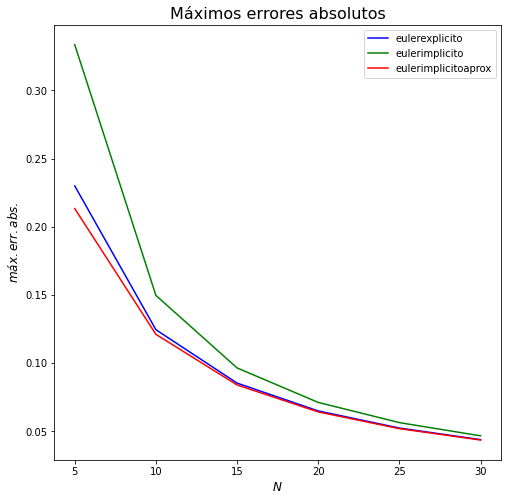

In [10]:
nv = [5+5*i for i in range(6)]
fig,ax = plt.subplots(figsize=(8,8))
colors = "bgr"
for metodo in metodos:
    ax.plot(nv,[abs([np.exp(p) for p in x[i]]-y[i][metodo]).max() for i in range(6)],colors[metodos.index(metodo)],label=metodo)
#ax.set_yscale("log")
ax.legend(loc='upper right')
ax.set_xlabel('$N$',fontsize=12)
ax.set_ylabel('$máx.err.abs.$',fontsize=12)
ax.set_title('Máximos errores absolutos',fontsize=16);

Podemos ver cómo, en general, el método implícito es computacionalmente el menos eficiente de todos, y Euler explícito es el más eficiente. Además, las aproximaciones más precisas son las de Euler implícito aproximado, seguido de las de Euler explícito y las de Euler implícito. En la última gráfica vemos cómo, a menor $h$ (mayor $N$) las aproximaciones son más precisas.

### Ejercicio 2

A partir de la implementación del algoritmo del método de Euler explícito, realice las modificaciones oportunas para obtener también las implementaciones correspondientes a los métodos de Euler mejorado (o del punto medio), así como del de Euler modificado (o de Heun).

#### Solución al ejercicio 2

In [11]:
%%file   eulermejorado.py
## módulo eulermejorado
''' método de Euler mejorado (o del punto medio) para resolver el PVI
    X,Y     = integrate(F,x0,y0,xfinal,N).
    {y}'    = {F(x,{y})}, donde
    {y}     = {y[0],y[1],...y[N-1]}.
    x0,y0   = condiciones iniciales 
    xfinal  = valor final de la variable x
    h       = incremento de x usado para la integración
    F       = función suplida por el usuario que devuelve 
            el array F(x,y) = {y'[0],y'[1],...,y'[N-1]}.
'''
import numpy as np
def integrate(F,x0,y0,xfinal,N):    
    X = np.linspace(x0,xfinal,N+1)
    Y = [y0]; h = (xfinal-x0)/N
    for n in range(N):
        Y.append(Y[n] + h*F(X[n]+h/2,Y[n]+h/2*F(X[n],Y[n])))
    return np.array(X),np.array(Y)

Overwriting eulermejorado.py


In [12]:
%%file   eulermodificado.py
## módulo eulermodificado
''' método de Euler modificado (o de Heun) para resolver el PVI
    X,Y     = integrate(F,x0,y0,xfinal,N).
    {y}'    = {F(x,{y})}, donde
    {y}     = {y[0],y[1],...y[N-1]}.
    x0,y0   = condiciones iniciales 
    xfinal  = valor final de la variable x
    h       = incremento de x usado para la integración
    F       = función suplida por el usuario que devuelve 
            el array F(x,y) = {y'[0],y'[1],...,y'[N-1]}.
'''
import numpy as np
def integrate(F,x0,y0,xfinal,N):    
    X = np.linspace(x0,xfinal,N+1)
    Y = [y0]; h = (xfinal-x0)/N
    for n in range(N):
        Y.append(Y[n] + h/2*(F(X[n],Y[n])+F(X[n+1],Y[n]+h*F(X[n],Y[n]))))
    return np.array(X),np.array(Y)

Overwriting eulermodificado.py


## Métodos de Taylor

### Ejercicio 3

Realice varios experimentos numéricos, con diferentes valores de $N$, y compare y ratifique los órdenes de convergencia de los diferentes métodos vistos hasta el momento.

#### Solución al ejercicio 3

Realizaremos las comparaciones con diferentes valores de $N$ para los métodos vistos hasta el momento:

* Método de Euler explícito: `eulerexplicito`
* Método de Euler implícito: `eulerimplicito`
* Método de Euler implícito aproximado: `eulerimplicitoaprox`
* Método de Euler mejorado (o del punto medio): `eulermejorado`
* Método de Euler modificado (o de Heun): `eulermodificado`
* Método de Taylor de orden 2: `taylor2`

(definimos aquí debajo el módulo `taylor2`)

In [13]:
%%file taylor2.py
## módulo taylor2
''' método del método de Taylor de orden 2 para resolver el PVI
    X,Y     = integrate(F,x0,y0,xfinal,N).
    {y}'    = {F(x,{y})}, donde
    {y}     = {y[0],y[1],...y[N-1]}.
    x0,y0   = condiciones iniciales 
    xfinal  = valor final de la variable x
    h       = incremento de x usado para la integración
    F       = función suplida por el usuario que devuelve 
            el array F(x,y) = {y'[0],y'[1],...,y'[N-1]}.
'''
def integrate(F,x0,y0,xfinal,N):  
    import numpy as np
    import sympy as sp
    
    t, z = sp.symbols('t, z')
    
    X = np.linspace(x0,xfinal,N+1)
    Y = [y0]; h = (xfinal-x0)/N
    
    def F1(t,z):
        return F(t,z)

    def F2(t,z):
        return sp.diff(F(t,z),t) + sp.diff(F(t,z),z)*F1(t,z)
    
    for n in range(N):
        Y.append(Y[n]+h*F1(X[n],Y[n])+h**2/2*F2(t,z).subs({t:X[n],z:Y[n]}))
    return np.array(X),np.array(Y)

Overwriting taylor2.py


Realizamos las comparaciones usando la función `comparar_metodos` del [ejercicio anterior](#):

In [14]:
metodos = ["eulerexplicito", "eulerimplicito", "eulerimplicitoaprox", "eulermejorado", "eulermodificado", "taylor2"]
x, y, tiempos = comparar_metodos(metodos, lambda i: 5+5*i, 6, f, a, ya, b)

Comparando los métodos ['eulerexplicito', 'eulerimplicito', 'eulerimplicitoaprox', 'eulermejorado', 'eulermodificado', 'taylor2']
Ejecutando 6 iteraciones de valores de N...
│ 
├── Calculando para i=0, N=5
│   ├── Finalizado método 'eulerexplicito'
│   │   └── Tiempo de ejecución: 0.0001789860034477897
│   ├── Finalizado método 'eulerimplicito'
│   │   └── Tiempo de ejecución: 0.03446962000452913
│   ├── Finalizado método 'eulerimplicitoaprox'
│   │   └── Tiempo de ejecución: 0.00020517299708444625
│   ├── Finalizado método 'eulermejorado'
│   │   └── Tiempo de ejecución: 0.00014623200695496053
│   ├── Finalizado método 'eulermodificado'
│   │   └── Tiempo de ejecución: 0.00015523500042036176
│   └── Finalizado método 'taylor2'
│       └── Tiempo de ejecución: 0.00952359099755995
├── Calculando para i=1, N=10
│   ├── Finalizado método 'eulerexplicito'
│   │   └── Tiempo de ejecución: 0.00023594500089529902
│   ├── Finalizado método 'eulerimplicito'
│   │   └── Tiempo de ejecución: 0.15

Text(0.5, 1.0, 'Tiempos de ejecución')

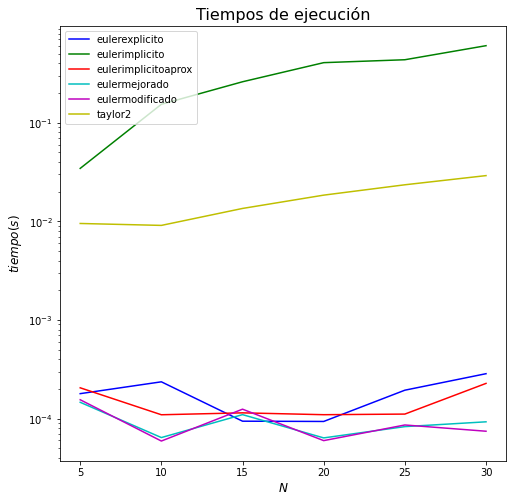

In [15]:
nv = [5+5*i for i in range(6)]
fig,ax = plt.subplots(figsize=(8,8))
colors = "bgrcmy"
for metodo in metodos:
    ax.plot(nv,[tiempos[i][metodo] for i in range(6)],colors[metodos.index(metodo)],label=metodo)
ax.set_yscale("log")
ax.legend(loc='upper left')
ax.set_xlabel('$N$',fontsize=12)
ax.set_ylabel('$tiempo (s)$',fontsize=12)
ax.set_title('Tiempos de ejecución',fontsize=16)

El método de euler implícito es el menos eficiente, seguido del método de Taylor de orden 2. El resto de métodos tienen una eficiencia similar.

Text(0.5, 1.0, 'Aproximaciones')

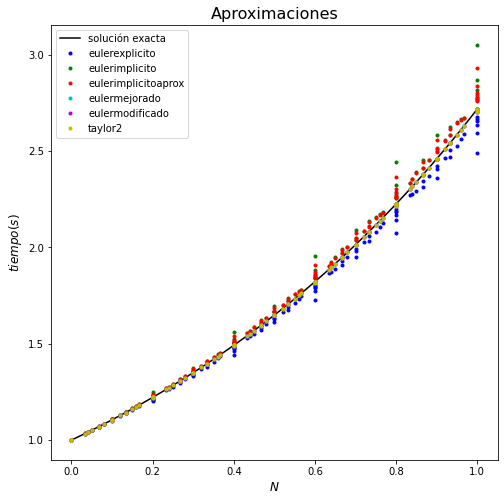

In [16]:
fig,ax = plt.subplots(figsize=(8,8))
xx = np.linspace(a,b,100)
yy = [np.exp(x) for x in xx]
colors = "bgrcmy"
ax.plot(xx,yy,'k',label='solución exacta')
for metodo in metodos:
    ax.plot(x[0],y[0][metodo],colors[metodos.index(metodo)]+'.',label=metodo)
    for i in range(1,6):
        ax.plot(x[i],y[i][metodo],colors[metodos.index(metodo)]+'.')
ax.legend(loc='upper left')
ax.set_xlabel('$N$',fontsize=12)
ax.set_ylabel('$tiempo (s)$',fontsize=12)
ax.set_title('Aproximaciones',fontsize=16)

Text(0.5, 1.0, 'Máximos errores absolutos')

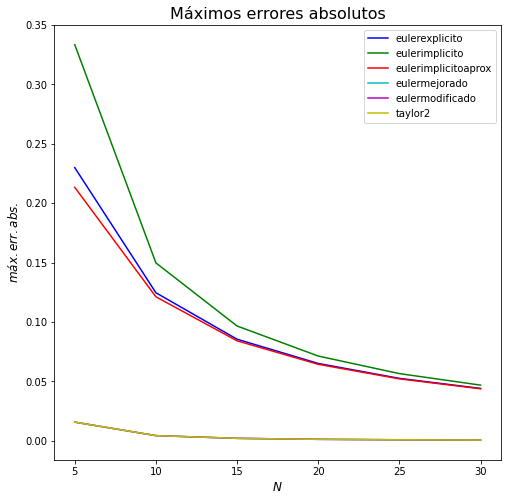

In [17]:
nv = [5+5*i for i in range(6)]
fig,ax = plt.subplots(figsize=(8,8))
colors = "bgrcmy"
for metodo in metodos:
    ax.plot(nv,[abs([np.exp(p) for p in x[i]]-y[i][metodo]).max() for i in range(6)],colors[metodos.index(metodo)],label=metodo)
#ax.set_yscale("log")
ax.legend(loc='upper right')
ax.set_xlabel('$N$',fontsize=12)
ax.set_ylabel('$máx.err.abs.$',fontsize=12)
ax.set_title('Máximos errores absolutos',fontsize=16)

Claramente, Taylor nos da la mejor aproximación. Compararemos a continuación los órdenes de convergencia.

### Ejercicio 4

A partir de la implementación del algoritmo del método de Taylor de orden $p=2$, realice las modificaciones oportunas para obtener también una posible implementación correspondiente al método de Taylor de orden $p=3$.

#### Solución al ejercicio 4

In [18]:
%%file taylor3.py
## módulo taylor3
''' método del método de Taylor de orden 3 para resolver el PVI
    X,Y     = integrate(F,x0,y0,xfinal,N).
    {y}'    = {F(x,{y})}, donde
    {y}     = {y[0],y[1],...y[N-1]}.
    x0,y0   = condiciones iniciales 
    xfinal  = valor final de la variable x
    h       = incremento de x usado para la integración
    F       = función suplida por el usuario que devuelve 
            el array F(x,y) = {y'[0],y'[1],...,y'[N-1]}.
'''
def integrate(F,x0,y0,xfinal,N):  
    import numpy as np
    import sympy as sp
    
    t, z = sp.symbols('t, z')
    
    X = np.linspace(x0,xfinal,N+1)
    Y = [y0]; h = (xfinal-x0)/N
    
    def F1(t,z):
        return F(t,z)

    def F2(t,z):
        return sp.diff(F(t,z),t) + sp.diff(F(t,z),z)*F1(t,z)
    
    def F3(t,z):
        return sp.diff(F2(t,z),t) + sp.diff(F2(t,z),z)*F1(t,z)
    
    for n in range(N):
        Y.append(Y[n]+h*F1(X[n],Y[n])+h**2/2*F2(t,z).subs({t:X[n],z:Y[n]})+h**3/6*F3(t,z).subs({t:X[n],z:Y[n]}))
    return np.array(X),np.array(Y)

Overwriting taylor3.py


## Métodos de Runge-Kutta

### Ejercicio 5

Repita las aproximaciones anteriores con diferentes valores de $N$ (y por tanto de $h$) y compruebe el efecto en cuanto a mayor o menor precisión, estabilidad y coste computacional.

#### Solución al ejercicio 5

Realizaremos las comparaciones con diferentes valores de $N$ para los métodos vistos hasta el momento:

* Método de Euler explícito: `eulerexplicito`
* Método de Euler implícito: `eulerimplicito`
* Método de Euler implícito aproximado: `eulerimplicitoaprox`
* Método de Euler mejorado (o del punto medio): `eulermejorado`
* Método de Euler modificado (o de Heun): `eulermodificado`
* Método de Taylor de orden 2: `taylor2`
* Método de Taylor de orden 3: `taylor3`
* Runge-Kutta clásico (de orde 4): `rk4`

(definimos aquí debajo el módulo `rk4`)

In [19]:
%%file rk4.py
## módulo rk4
''' Método de Runge-Kutta de cuarto orden para resolver
    el problema de valores iniciales {y}' = {F(x,{y})}, 
    donde    {y} = {y[0],y[1],...y[N-1]}.
    X,Y    = integrate(F,x0,y0,xfinal,h).
    x0,y0  = condiciones iniciales
    xfinal = valor final de x
    N      = número de subintervalos de la partición
    h      = incremento de x usado en la integración
    F      = función suplida por el usuario que devuelve el
            array F(x,y) = {y'[0],y'[1],...,y'[N-1]}.
'''
import numpy as np
def integrate(F,x0,y0,xfinal,N):
    
    def RK4(F,xn,yn,h):
        K1 = F(xn,yn)
        K2 = F(xn + h/2, yn + K1*h/2)
        K3 = F(xn + h/2, yn + K2*h/2)
        K4 = F(xn + h  , yn + K3*h)
        return (K1 + 2*K2 + 2*K3 + K4)/6    
    
    X = np.linspace(x0,xfinal,N+1)
    Y = [y0]; h = (xfinal-x0)/N
    for n in range(N):
        Y.append( Y[n] + h*RK4(F,X[n],Y[n],h) )
    return np.array(X),np.array(Y)

Overwriting rk4.py


El estudio de la precisión y del coste computacional será análogo a los ejercicios anteriores junto con RK4.

In [20]:
metodos = ["eulerexplicito", "eulerimplicito", "eulerimplicitoaprox", "eulermejorado", "eulermodificado", "taylor2", "taylor3", "rk4"]
x, y, tiempos = comparar_metodos(metodos, lambda i: 5+5*i, 6, f, a, ya, b)

Comparando los métodos ['eulerexplicito', 'eulerimplicito', 'eulerimplicitoaprox', 'eulermejorado', 'eulermodificado', 'taylor2', 'taylor3', 'rk4']
Ejecutando 6 iteraciones de valores de N...
│ 
├── Calculando para i=0, N=5
│   ├── Finalizado método 'eulerexplicito'
│   │   └── Tiempo de ejecución: 0.00017057700461009517
│   ├── Finalizado método 'eulerimplicito'
│   │   └── Tiempo de ejecución: 0.03916923399810912
│   ├── Finalizado método 'eulerimplicitoaprox'
│   │   └── Tiempo de ejecución: 0.00010720999853219837
│   ├── Finalizado método 'eulermejorado'
│   │   └── Tiempo de ejecución: 5.6341996241826564e-05
│   ├── Finalizado método 'eulermodificado'
│   │   └── Tiempo de ejecución: 5.159399734111503e-05
│   ├── Finalizado método 'taylor2'
│   │   └── Tiempo de ejecución: 0.004501928997342475
│   ├── Finalizado método 'taylor3'
│   │   └── Tiempo de ejecución: 0.016985722999379504
│   └── Finalizado método 'rk4'
│       └── Tiempo de ejecución: 0.00014842100063106045
├── Calculan

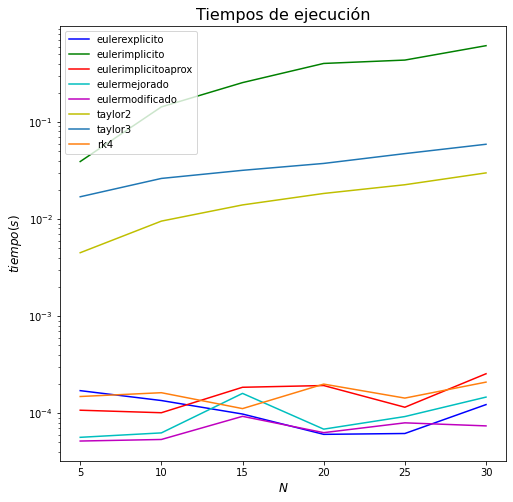

In [21]:
nv = [5+5*i for i in range(6)]
fig,ax = plt.subplots(figsize=(8,8))
colors = ['b','g','r','c','m','y','C0','C1']
for metodo in metodos:
    ax.plot(nv,[tiempos[i][metodo] for i in range(6)],colors[metodos.index(metodo)],label=metodo)
ax.set_yscale("log")
ax.legend(loc='upper left')
ax.set_xlabel('$N$',fontsize=12)
ax.set_ylabel('$tiempo (s)$',fontsize=12)
ax.set_title('Tiempos de ejecución',fontsize=16);

Text(0.5, 1.0, 'Aproximaciones')

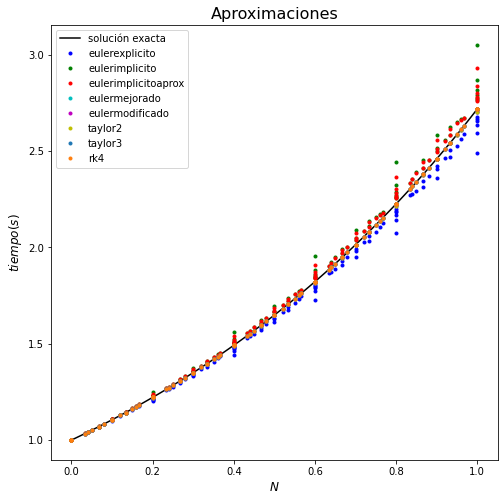

In [22]:
fig,ax = plt.subplots(figsize=(8,8))
xx = np.linspace(a,b,100)
yy = [np.exp(x) for x in xx]
colors = ['b','g','r','c','m','y','C0','C1']
ax.plot(xx,yy,'k',label='solución exacta')
for metodo in metodos:
    ax.plot(x[0],y[0][metodo],colors[metodos.index(metodo)]+'.',label=metodo)
    for i in range(1,6):
        ax.plot(x[i],y[i][metodo],colors[metodos.index(metodo)]+'.')
ax.legend(loc='upper left')
ax.set_xlabel('$N$',fontsize=12)
ax.set_ylabel('$tiempo (s)$',fontsize=12)
ax.set_title('Aproximaciones',fontsize=16)

Text(0.5, 1.0, 'Máximos errores absolutos')

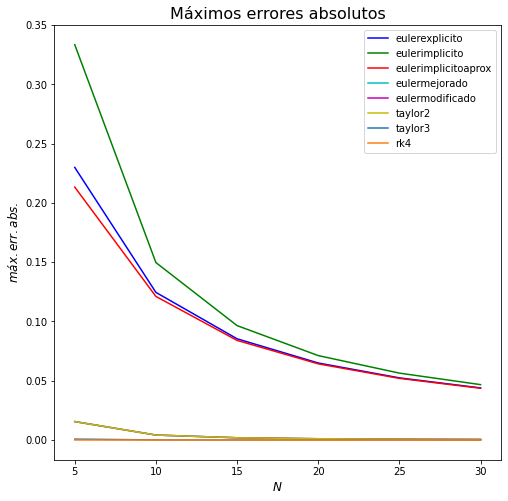

In [23]:
nv = [5+5*i for i in range(6)]
fig,ax = plt.subplots(figsize=(8,8))
colors = ['b','g','r','c','m','y','C0','C1']
for metodo in metodos:
    ax.plot(nv,[abs([np.exp(p) for p in x[i]]-y[i][metodo]).max() for i in range(6)],colors[metodos.index(metodo)],label=metodo)
#ax.set_yscale("log")
ax.legend(loc='upper right')
ax.set_xlabel('$N$',fontsize=12)
ax.set_ylabel('$máx.err.abs.$',fontsize=12)
ax.set_title('Máximos errores absolutos',fontsize=16)

Text(0.5, 1.0, 'Máximos errores absolutos')

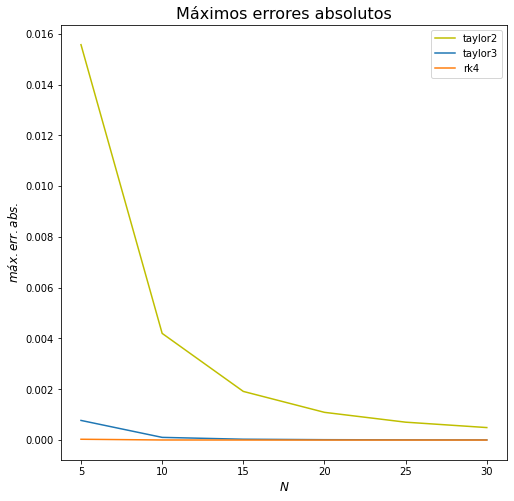

In [24]:
nv = [5+5*i for i in range(6)]
fig,ax = plt.subplots(figsize=(8,8))
colors = ['b','g','r','c','m','y','C0','C1']
for metodo in metodos:
    if metodo not in metodos[:5]:
        ax.plot(nv,[abs([np.exp(p) for p in x[i]]-y[i][metodo]).max() for i in range(6)],colors[metodos.index(metodo)],label=metodo)
#ax.set_yscale("log")
ax.legend(loc='upper right')
ax.set_xlabel('$N$',fontsize=12)
ax.set_ylabel('$máx.err.abs.$',fontsize=12)
ax.set_title('Máximos errores absolutos',fontsize=16)

Vemos que el orden de convergencia es mayor en el caso de RK4 (la convergencia a la solución es más rápida). Por otra parte, todos los métodos obtenidos son estables.

### Ejercicio 6

A partir de la implementación del algoritmo del método de Runge-Kutta de 4 evaluaciones, realice las modificaciones oportunas para intentar obtener también las implementaciones correspondientes a otros muchos métodos de tipo Runge-Kutta, tanto explícitos como implícitos, a partir del correspondiente arreglo de Butcher.

#### Solución al ejercicio 6

Dado que un método de Runge-Kutta queda determinado por su arreglo de Butcher, crearemos un módulo `rk` en el que podremos calcular cualquier método Runge-Kutta.

> Tras probar diversas implementaciones, no he logrado obtener una forma correcta de calcular el método en el caso implícito. En el caso de los RK implícitos, podríamos programarlo de forma "manual" al igual que los métodos anteriores, haciendo uso de los `solve` de `sympy` o `numpy`.

Este módulo no sólo integra la función `integrate`, sino que también contiene una clase, `Butcher`, para poder manejar de una forma más versátil los arreglos de Butcher.

In [25]:
%%file rk.py
## módulo rk

class Butcher:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c
    
    def __repr__(self):
        s = ''
        for i in range(len(self.a)):
            s += "{: >6} │ ".format(str(self.c[i])[:6])
            for j in range(len(self.a)):
                s += "{: >6} ".format(str(self.a[i][j])[:6])
            s += '\n'
        s += "───────┼─"
        for i in range(len(self.a)):
            s += "───────"
        s += "\n       │ "
        for i in range(len(self.a)):
            s += "{: >6} ".format(str(self.b[i])[:6])
        return s
    
    @classmethod
    def from_matrix(self,matrix):
        a = []
        b = []
        c = []
        for i in range(len(matrix)-1):
            c.append(matrix[i][0])
            b.append(matrix[len(matrix)-1][i+1])
            v = []
            for j in range(len(matrix)-1):
                v.append(matrix[i][j+1])
            a.append(v)
        return Butcher(a,b,c)

    def is_explicit(self):
        explicit = True
        for i in range(len(self.a)):
            for j in range(i+1, len(self.a)):
                if self.a[i][j] != 0:
                    explicit = False
        return explicit


''' método Runge-Kutta explícito para resolver el PVI a partir de un arreglo de Butcher
    X,Y     = integrate(F,x0,y0,xfinal,N).
    {y}'    = {F(x,{y})}, donde
    {y}     = {y[0],y[1],...y[N-1]}.
    x0,y0   = condiciones iniciales 
    xfinal  = valor final de la variable x
    h       = incremento de x usado para la integración
    F       = función suplida por el usuario que devuelve 
            el array F(x,y) = {y'[0],y'[1],...,y'[N-1]}.
    butcher = arreglo de Butcher para el método
'''
def integrate(F,x0,y0,xfinal,butcher,N):
    import numpy as np
    
    if ( butcher.is_explicit() ):
        def phi(F,x0,y0,h,butcher):
            tam = len(butcher.a)
            k0 = F(x0,y0)
            k = np.array([k0])
            
            for i in range(1, tam):
                kx = 0
                for j in range(i):
                    kx += k[j] * butcher.a[i][j]
                k = np.append(k, F(x0 + h*butcher.c[i], y0 + h*kx))
                
            return np.dot(butcher.b, k)

        
        X = np.linspace(x0,xfinal,N+1)
        Y = [y0]; h = (xfinal-x0)/N
        
        for n in range(N):
            Y.append( Y[n] + h*phi(F,X[n],Y[n],h, butcher) )
        
        return np.array(X),np.array(Y)
    else:
        print("Debe tratarse de un método explicito")
        return None

Overwriting rk.py


En el módulo `rk` hemos definido una clase, `Butcher`. Esta clase es la que el método `integrate` tomará como parámetro para el método de Runge-Kutta. Por ejemplo, veamos que podemos expresar RK2 explícito como:

In [26]:
import rk

alpha = 1/2
beta = 1
butcher_rk2 = rk.Butcher(
    b=[1-alpha, alpha],
    c=[0, beta],
    a=[[0,0],[beta,0]]
)

In [27]:
butcher_rk2

     0 │      0      0 
     1 │      1      0 
───────┼───────────────
       │    0.5    0.5 

Y ahora podemos usar RK2 para aproximar nuestra $f$:

In [28]:
rk.integrate(f,a,ya,b,butcher_rk2,10)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([1.        , 1.105     , 1.221025  , 1.34923262, 1.49090205,
        1.64744677, 1.82042868, 2.01157369, 2.22278892, 2.45618176,
        2.71408085]))

Comprobaremos que nuestra implementación es correcta comparando los valores de RK4 obtenidos anteriormente en el módulo `rk4`

In [29]:
import rk4; rk4.integrate(f,a,ya,b,10)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([1.        , 1.10517083, 1.22140257, 1.3498585 , 1.49182424,
        1.64872064, 1.82211796, 2.01375163, 2.22553956, 2.45960141,
        2.71827974]))

con el nuevo módulo `rk`. Nótese que, además, la clase `rk.Butcher` nos permite introducir arreglos de Butcher en forma matricial. El arreglo de Butcher de RK4 es$$\left(\begin{array}
{c|cccc}
0\\
1/2 & 1/2\\
1/2 & 0 &1/2 \\
1& 0& 0& 1\\
\hline
& 1/6 & 1/3 & 1/3 & 1/6
\end{array}\right)$$

Observemos cómo los resultados coinciden:

In [30]:
rk.integrate(
    f,a,ya,b,
    rk.Butcher.from_matrix([
        [0, 0, 0, 0, 0],
        [1/2, 1/2, 0, 0, 0],
        [1/2, 0, 1/2, 0, 0],
        [1, 0, 0, 1, 0],
        [None, 1/6, 1/3, 1/3, 1/6] # el elemento de la esquina inferior izquierda será ignorado
    ]),
    10)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([1.        , 1.10517083, 1.22140257, 1.3498585 , 1.49182424,
        1.64872064, 1.82211796, 2.01375163, 2.22553956, 2.45960141,
        2.71827974]))

## Métodos multipaso lineales (MML)

### Ejercicio 7

A partir de la implementación del algoritmo del método de Adams-Bashforth anterior, realice las modificaciones oportunas para intentar obtener también las implementaciones correspondientes a otros muchos métodos de tipo Adams, como Adams-Moulton (AM), Milne-Simpson, Nyström y/o Newton-Cotes.

#### Solución al ejercicio 7

Para un método de $k$ pasos son necesarias las semillas$$x_0, x_1, ..., x_{k-1}$$
Calcularemos $x_1,...,x_{k-1}$ con Euler. Programaremos el método de Adams-Moulton con $k=2$, que es
$$x_{n+2}=x_{n+1}+h\left(\frac{5}{12}f_{n+2}+\frac{2}{3}f_{n+1}-\frac{1}{12}f_n\right)$$
y con $k=3$, que es
$$x_{n+3}=x_{n+2}+h\left(\frac{9}{24}f_{n+3}+\frac{19}{24}f_{n+2}-\frac{5}{24}f_{n+1}+\frac{1}{24}f_n\right)$$

In [31]:
%%file am2.py
## módulo am2
''' Método de Adams-Moulton (con k = 2) para resolver
    el problema de valores iniciales {y}' = {F(x,{y})}, 
    donde    {y} = {y[0],y[1],...y[N-1]}.
    X,Y    = integrate(F,x0,y0,xfinal,N).
    x0,y0  = condiciones iniciales
    xfinal = valor final de x
    N      = número de subintervalos de la partición
    h      = incremento de x usado en la integración
    F      = función suplida por el usuario que devuelve el
            array F(x,y) = {y'[0],y'[1],...,y'[N-1]}.
'''

def integrate(F,x0,y0,xfinal,N):
    
    import numpy as np
    
    def AM2(F,x0,y0,y1,y2,h):
        return 5/12*F(x0+2*h, y2) + 2/3*F(x0+h, y1) - 1/12*F(x0,y0)
    
    X = np.linspace(x0,xfinal,N+1)
    h = (xfinal-x0)/N
    y1 = y0 + h*F(x0,y0); Y = [y0,y1]
    for n in range(N-1):
        Y.append(sp.solve(Y[n]+h*AM2(F,X[n],Y[n],Y[n+1],y2,h)-y2,y2)[0])
    return np.array(X),np.array(Y)

Overwriting am2.py


In [32]:
%%file am3.py
## módulo am3
''' Método de Adams-Moulton (con k = 3) para resolver
    el problema de valores iniciales {y}' = {F(x,{y})}, 
    donde    {y} = {y[0],y[1],...y[N-1]}.
    X,Y    = integrate(F,x0,y0,xfinal,N).
    x0,y0  = condiciones iniciales
    xfinal = valor final de x
    N      = número de subintervalos de la partición
    h      = incremento de x usado en la integración
    F      = función suplida por el usuario que devuelve el
            array F(x,y) = {y'[0],y'[1],...,y'[N-1]}.
'''

def integrate(F,x0,y0,xfinal,N):
    
    import numpy as np
    
    def AM3(F,x0,y0,y1,y2,y3,h):
        return 9/24*F(x0+3*h, y3) + 19/24*F(x0+2*h, y2) - 5/24*F(x0+h, y1) + 1/24*F(x0, y0)
    
    X = np.linspace(x0,xfinal,N+1)
    h = (xfinal-x0)/N
    Y = [y0]
    for i in range(3-1):  # num_pasos - 1
        y1 = y0 + h*F(x0,y0)
        Y.append(y1)
        y0 = y1
        
    for n in range(N-1):
        Y.append(sp.solve(Y[n]+h*AM3(F,X[n],Y[n],Y[n+1],Y[n+2],y3,h)-y3,y2)[0])
    return np.array(X),np.array(Y)

Overwriting am3.py


## Métodos predictor-corrector

### Ejercicio 8

Intente la implementación del algoritmo de tipo Predictor-Corrector anterior, o cualquier otro adecuado, eligiendo convenientemente los otros métodos necesarios para proporcionar los valores previos necesarios.

#### Solución al ejercicio 8

Implementaremos el siguiente método predictor-corrector, compuesto por un predictor Adams-Bashforth de 3 pasos y un corrector Adam-Bashforth-Moulton de 4 pasos, como sigue:

P: $y_{n+3}^{(0)} = y_{n+2} + h \left(\frac{23}{12}f_{n+2}-\frac{4}{3}f_{n+1}+\frac{5}{12}f_n\right)$

C$^1$: $y_{n+4} = y_{n+3} + h \left(\frac{3}{8} f(t_{n+4},y_{n+4}^{(0)}) +\frac{19}{24} f_{n+3} -\frac{5}{24} f_{n+2} + \frac{1}{24} f_{n+1}\right)$ 

In [33]:
%%file pcabm3.py
## módulo pcamb3
''' Método predictor-corrector Adams-Bashforth-Moulton de orden 3 para resolver
    el problema de valores iniciales {y}' = {F(x,{y})}, 
    donde    {y} = {y[0],y[1],...y[N-1]}.
    X,Y    = integrate(F,x0,y0,xfinal,N).
    x0,y0  = condiciones iniciales
    xfinal = valor final de x
    N      = número de subintervalos de la partición
    h      = incremento de x usado en la integración
    F      = función suplida por el usuario que devuelve el
            array F(x,y) = {y'[0],y'[1],...,y'[N-1]}.
'''

def integrate(F,x0,y0,xfinal,N):
    import numpy as np
    import eulerexplicito
    
    h = (xfinal-x0)/N
    X = np.linspace(x0,xfinal,N+1)
    Y = np.zeros(N+1)
    
    # otra forma de calcular las semillas es haciendo uso de los métodos de un paso definidos
    # anteriormente; en este caso volveremos a usar Euler explicito para x_1,...,x_4
    _, Y[0:3] = eulerexplicito.integrate(F,x0,y0,x0+2*h,2)
    
    K1 = F(X[1],Y[1])
    K2 = F(X[0],Y[0])
    for i in range(2,N):
        K3 = K2
        K2 = K1
        K1 = F(X[i],Y[i])
        # predictor
        Y[i+1] = Y[i] + h*(23*K1-16*K2+5*K3)/12
        K0 = F(X[i+1],Y[i+1])
        # corrector
        Y[i+1] = Y[i] + h*(9*K0+19*K1-5*K2+K3)/24
    return np.array(X),np.array(Y)
    """
    _, Y[0:5] = eulerexplicito.integrate(F,x0,y0,x0+4*h,4)
    
    
    K1 = F(X[3],Y[3])
    K2 = F(X[2],Y[2])
    K3 = F(X[1],Y[1])
    K4 = F(X[0],Y[0])
    
    for i in range(4,N):
        K5 = K4
        K4 = K3
        K3 = K2
        K2 = K1
        K1 = F(X[i],Y[i])
        # predictor
        Y[i+1] = Y[i] + h/270*(1901*K1-2744*K2+2616*K3-1274*K4+251*K5)
        K0 = F(X[i+1],Y[i+1])
        # corrector
        Y[i+1] = Y[i] + h/270*(251*K0+646*K1-264*K2+106*K3-19*K4)
    return np.array(X),np.array(Y)
    """

Overwriting pcabm3.py


In [34]:
import pcabm3
x, y = pcabm3.integrate(f,a,ya,b,10)
y

array([1.        , 1.1       , 1.21      , 1.33717604, 1.47783462,
       1.63325917, 1.80502863, 1.99486318, 2.20466261, 2.4365266 ,
       2.69277569])

Vemos como este método aproxima bastante bien:

Text(0.5, 1.0, 'Aproximaciones')

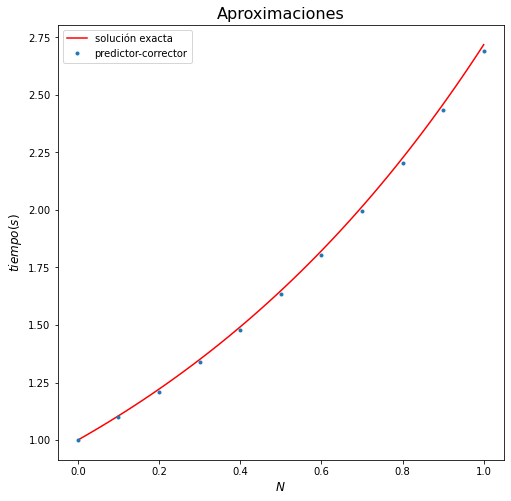

In [35]:
fig,ax = plt.subplots(figsize=(8,8))
xx = np.linspace(a,b,100)
yy = [np.exp(x) for x in xx]
ax.plot(xx,yy,'r',label='solución exacta')
ax.plot(x,y,'C0.',label='predictor-corrector')
ax.legend(loc='upper left')
ax.set_xlabel('$N$',fontsize=12)
ax.set_ylabel('$tiempo (s)$',fontsize=12)
ax.set_title('Aproximaciones',fontsize=16)